In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import re
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def extract_answer(text):
    pattern = r"(True|False|Don't know)"
    matches = re.findall(pattern, text)
    return matches

def process_df(prompt_response_df, rag_response_df):
    prompt_response_df.loc[:, "answer_count"] = prompt_response_df.extracted_answer.apply(lambda x:len(x))
    prompt_response_df_multiple_answers = prompt_response_df[prompt_response_df.answer_count > 1]
    prompt_response_df_single_answer = prompt_response_df.drop(prompt_response_df_multiple_answers.index)
    prompt_response_df_single_answer.drop("answer_count", axis=1, inplace=True)
    prompt_response_df_multiple_answers_ = []
    for index, row in prompt_response_df_multiple_answers.iterrows():
        if row["extracted_answer"][0] == row["extracted_answer"][1]:
            prompt_response_df_multiple_answers_.append((row["question"], row["label"], row["llm_answer"], row["extracted_answer"][0]))
        else:
            prompt_response_df_multiple_answers_.append((row["question"], row["label"], row["llm_answer"], None))
    prompt_response_df_multiple_answers_ = pd.DataFrame(prompt_response_df_multiple_answers_, columns=["question", "label", "llm_answer", "extracted_answer"])
    prompt_response_df_final = pd.concat([prompt_response_df_single_answer, prompt_response_df_multiple_answers_], ignore_index=True)
    prompt_response_df_final = prompt_response_df_final.explode("extracted_answer")

    rag_response_df.loc[:, "answer_count"] = rag_response_df.extracted_answer.apply(lambda x:len(x))
    rag_response_df_multiple_answers = rag_response_df[rag_response_df.answer_count > 1]
    rag_response_df_single_answer = rag_response_df.drop(rag_response_df_multiple_answers.index)
    rag_response_df_single_answer.drop("answer_count", axis=1, inplace=True)
    rag_response_df_multiple_answers_ = []
    for index, row in rag_response_df_multiple_answers.iterrows():
        if row["extracted_answer"][0] == row["extracted_answer"][1]:
            rag_response_df_multiple_answers_.append((row["question"], row["label"], row["llm_answer"], row["extracted_answer"][0]))
        else:
            rag_response_df_multiple_answers_.append((row["question"], row["label"], row["llm_answer"], None))
    rag_response_df_multiple_answers_ = pd.DataFrame(rag_response_df_multiple_answers_, columns=["question", "label", "llm_answer", "extracted_answer"])
    rag_response_df_final = pd.concat([rag_response_df_single_answer, rag_response_df_multiple_answers_], ignore_index=True)
    rag_response_df_final = rag_response_df_final.explode("extracted_answer")
    
    prompt_incorrect_answers_because_of_na = prompt_response_df_final[prompt_response_df_final.extracted_answer.isna()]
    rag_incorrect_answers_because_of_na = rag_response_df_final[rag_response_df_final.extracted_answer.isna()]

    row_index_to_drop = list(prompt_incorrect_answers_because_of_na.index.values) + list(rag_incorrect_answers_because_of_na.index.values)

    prompt_response_df_final.drop(row_index_to_drop, inplace=True)
    rag_response_df_final.drop(row_index_to_drop, inplace=True)

    prompt_response_df_final = prompt_response_df_final.reset_index()
    rag_response_df_final = rag_response_df_final.reset_index()
    response_transform = {
        "True" : True,
        "False" : False
    }

    prompt_response_df_final.extracted_answer = prompt_response_df_final.extracted_answer.apply(lambda x:response_transform[x])
    rag_response_df_final.extracted_answer = rag_response_df_final.extracted_answer.apply(lambda x:response_transform[x])

    return prompt_response_df_final, rag_response_df_final


def evaluate(df):
    correct = df[df.label == df.extracted_answer]
    incorrect = df[df.label != df.extracted_answer]
    correct_frac = correct.shape[0]/df.shape[0]
    incorrect_frac = incorrect.shape[0]/df.shape[0]
    return correct_frac, incorrect_frac


def bootstrap(prompt_response_df_final, rag_response_df_final, niter = 1000, nsample = 150):
    prompt_correct_frac_list = []
    rag_correct_frac_list = []
    for i in tqdm(range(niter)):
        prompt_response_df_final_sample = prompt_response_df_final.sample(n=nsample, random_state=i)
        prompt_correct_frac, prompt_incorrect_frac = evaluate(prompt_response_df_final_sample)
        rag_response_df_final_sample = rag_response_df_final.iloc[prompt_response_df_final_sample.index]
        rag_correct_frac, rag_incorrect_frac = evaluate(rag_response_df_final_sample)
        prompt_correct_frac_list.append(prompt_correct_frac)
        rag_correct_frac_list.append(rag_correct_frac)
    return prompt_correct_frac_list, rag_correct_frac_list

def plot_figure(prompt_correct_frac_list, rag_correct_frac_list):
    fig = plt.figure(figsize=(5, 3))
    ax = plt.gca()

    sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
    sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)

    for artist in ax.lines:
        artist.set_edgecolor("black")

    plt.xlabel("Accuracy")
    plt.ylabel("Density")
    plt.legend(loc="upper left")
    plt.xlim(0.75,1)

    ax.axvline(np.mean(prompt_correct_frac_list), color='black', linestyle='--', lw=2)
    ax.axvline(np.mean(rag_correct_frac_list), color='black', linestyle='--', lw=2)

    sns.despine(top=True, right=True)

    plt.show()
    return fig



In [3]:
'''
Following files can be obtained by running the run_true_false_generation.py script.
Make sure to change the parent path and filenames based on where and how you save the files
'''

data_path ='../data/results'

llama_prompt_path = os.path.join(data_path, 'Llama_2_13b_chat_hf_prompt_based_true_false_binary_response.csv')
llama_kg_rag_path = os.path.join(data_path, 'Llama_2_13b_chat_hf_PubMedBert_and_entity_recognition_based_node_retrieval_rag_based_true_false_binary_response.csv')

gpt_35_prompt_path = os.path.join(data_path, 'gpt_35_turbo_prompt_based_true_false_binary_response.csv')
gpt_35_kg_rag_path = os.path.join(data_path, 'gpt_35_turbo_PubMedBert_and_entity_recognition_based_node_retrieval_rag_based_true_false_binary_response.csv')

gpt_4_prompt_path = os.path.join(data_path, 'gpt_4_prompt_based_true_false_binary_response.csv')
gpt_4_kg_rag_path = os.path.join(data_path, 'gpt_4_PubMedBert_and_entity_recognition_based_node_retrieval_rag_based_true_false_binary_response.csv')

curated_data = pd.read_csv('../data/benchmark_data/true_false_questions.csv').drop('Unnamed: 0', axis=1)


In [4]:
llama_prompt_df = pd.read_csv(llama_prompt_path)
llama_prompt_df = pd.merge(curated_data, llama_prompt_df, left_on='text', right_on='question').drop(['text', 'label_y'], axis=1).rename(columns={'label_x':'label'})

llama_kg_rag_df = pd.read_csv(llama_kg_rag_path)
llama_kg_rag_df = pd.merge(curated_data, llama_kg_rag_df, left_on='text', right_on='question').drop(['text', 'label_y'], axis=1).rename(columns={'label_x':'label'})

gpt_35_prompt_df = pd.read_csv(gpt_35_prompt_path)
gpt_35_prompt_df = pd.merge(curated_data, gpt_35_prompt_df, left_on='text', right_on='question').drop(['text', 'label_y'], axis=1).rename(columns={'label_x':'label'})

gpt_35_kg_rag_df = pd.read_csv(gpt_35_kg_rag_path)
gpt_35_kg_rag_df = pd.merge(curated_data, gpt_35_kg_rag_df, left_on='text', right_on='question').drop(['text', 'label_y'], axis=1).rename(columns={'label_x':'label'})

gpt_4_prompt_df = pd.read_csv(gpt_4_prompt_path)
gpt_4_prompt_df = pd.merge(curated_data, gpt_4_prompt_df, left_on='text', right_on='question').drop(['text', 'label_y'], axis=1).rename(columns={'label_x':'label'})

gpt_4_kg_rag_df = pd.read_csv(gpt_4_kg_rag_path)
gpt_4_kg_rag_df = pd.merge(curated_data, gpt_4_kg_rag_df, left_on='text', right_on='question').drop(['text', 'label_y'], axis=1).rename(columns={'label_x':'label'})


In [5]:
llama_prompt_df.loc[:, 'extracted_answer'] = llama_prompt_df['llm_answer'].apply(extract_answer)
llama_kg_rag_df.loc[:, 'extracted_answer'] = llama_kg_rag_df['llm_answer'].apply(extract_answer)

gpt_35_prompt_df.loc[:, 'extracted_answer'] = gpt_35_prompt_df['llm_answer'].apply(extract_answer)
gpt_35_kg_rag_df.loc[:, 'extracted_answer'] = gpt_35_kg_rag_df['llm_answer'].apply(extract_answer)

gpt_4_prompt_df.loc[:, 'extracted_answer'] = gpt_4_prompt_df['llm_answer'].apply(extract_answer)
gpt_4_kg_rag_df.loc[:, 'extracted_answer'] = gpt_4_kg_rag_df['llm_answer'].apply(extract_answer)

llama_prompt_df, llama_kg_rag_df = process_df(llama_prompt_df, llama_kg_rag_df)

gpt_35_prompt_df, gpt_35_kg_rag_df = process_df(gpt_35_prompt_df, gpt_35_kg_rag_df)

gpt_4_prompt_df, gpt_4_kg_rag_df = process_df(gpt_4_prompt_df, gpt_4_kg_rag_df)


In [6]:
llama_prompt_correct_frac_list, llama_rag_correct_frac_list = bootstrap(llama_prompt_df, llama_kg_rag_df)

gpt_35_prompt_correct_frac_list, gpt_35_rag_correct_frac_list = bootstrap(gpt_35_prompt_df, gpt_35_kg_rag_df)

gpt_4_prompt_correct_frac_list, gpt_4_rag_correct_frac_list = bootstrap(gpt_4_prompt_df, gpt_4_kg_rag_df)


100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1168.13it/s]


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_52094/309868377.py:80: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_52094/309868377.py:81: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


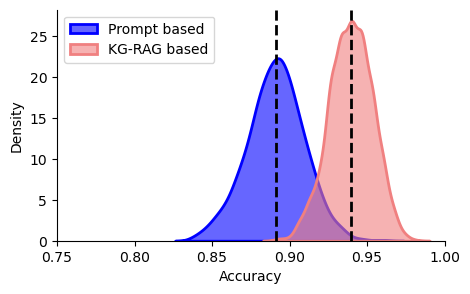

---Prompt based mean and std---
0.8909533333333334
0.018290921852717596

---KG-RAG based mean and std---
0.9394266666666666
0.013815617571751504


In [7]:
llama_fig = plot_figure(llama_prompt_correct_frac_list, llama_rag_correct_frac_list)

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
llama_fig.savefig(os.path.join(fig_path, 'llama_true_false.svg'), format='svg', bbox_inches='tight')      

print('---Prompt based mean and std---')
print(np.mean(llama_prompt_correct_frac_list))
print(np.std(llama_prompt_correct_frac_list))
print('')
print('---KG-RAG based mean and std---')
print(np.mean(llama_rag_correct_frac_list))
print(np.std(llama_rag_correct_frac_list))


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_52094/309868377.py:80: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_52094/309868377.py:81: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


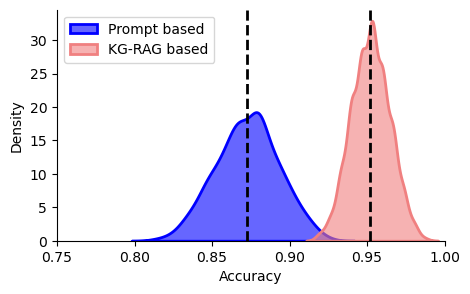

---Prompt based mean and std---
0.87268
0.020258766003880886

---KG-RAG based mean and std---
0.9521866666666666
0.012250017687062069


In [8]:
gpt_35_fig = plot_figure(gpt_35_prompt_correct_frac_list, gpt_35_rag_correct_frac_list)

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
gpt_35_fig.savefig(os.path.join(fig_path, 'gpt_35_true_false.svg'), format='svg', bbox_inches='tight')      

print('---Prompt based mean and std---')
print(np.mean(gpt_35_prompt_correct_frac_list))
print(np.std(gpt_35_prompt_correct_frac_list))
print('')
print('---KG-RAG based mean and std---')
print(np.mean(gpt_35_rag_correct_frac_list))
print(np.std(gpt_35_rag_correct_frac_list))


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_52094/309868377.py:80: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_52094/309868377.py:81: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


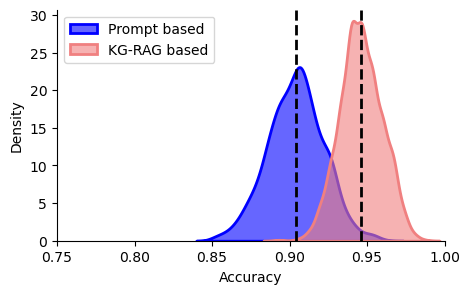

---Prompt based mean and std---
0.9039666666666666
0.017877328908114005

---KG-RAG based mean and std---
0.9459866666666666
0.013465339868632277


In [9]:
gpt_4_fig = plot_figure(gpt_4_prompt_correct_frac_list, gpt_4_rag_correct_frac_list)

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
gpt_4_fig.savefig(os.path.join(fig_path, 'gpt_4_true_false.svg'), format='svg', bbox_inches='tight')      

print('---Prompt based mean and std---')
print(np.mean(gpt_4_prompt_correct_frac_list))
print(np.std(gpt_4_prompt_correct_frac_list))
print('')
print('---KG-RAG based mean and std---')
print(np.mean(gpt_4_rag_correct_frac_list))
print(np.std(gpt_4_rag_correct_frac_list))
